[0.1, 0.7631185855919326, 1.291375245358284, 0.007847999999999994, -0.37853336594688286, 1.0370690723283076, 2700, 2700, 2700, 2700, 15.000205302275031]
[0.2, 1.5262371711838651, 2.582750490716568, 0.02982239999999998, -0.3794561468855437, 1.0370690723283078, 2860, 2860, 2860, 2860, 15.001609494502114]
[0.3, 2.2893557567757976, 3.874125736074852, 0.07094591999999997, -0.3803611064716113, 1.0370690723283076, 2988, 2988, 2988, 2988, 15.005636087474565]
[0.4, 3.05247434236773, 5.165500981433136, 0.13523673599999994, -0.38124023867098505, 1.0370690723283078, 3090, 3090, 3090, 3090, 15.013771375047462]
[0.5, 3.8155929279596625, 6.456876226791421, 0.22590938879999994, -0.38208705427962625, 1.0370690723283076, 3172, 3172, 3172, 3172, 15.027380110870254]
[0.6, 4.578711513551595, 7.748251472149705, 0.3455355110399999, -0.38289627743360866, 1.0370690723283076, 3237, 3237, 3237, 3237, 15.047625756650712]
[0.7, 5.341830099143528, 9.03962671750799, 0.49617240883199987, -0.3836636021811904, 1.037069

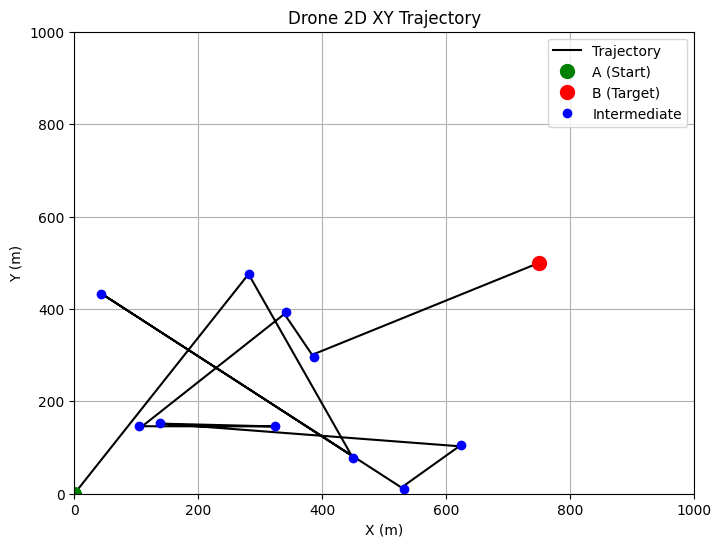

In [56]:
import csv
import numpy as np
import time
import matplotlib.pyplot as plt
import math

# ---------------- World Class ----------------
class World:
    def __init__(self, grid_size=10, max_world_size=1000):
        """
        Initialize the world grid.
        
        :param grid_size: Size of one grid cell.
        :param max_world_size: Maximum number of cells in one dimension.
        """
        self.grid_size = grid_size
        self.max_world_size = max_world_size
        self.grid = {}

    def get_area(self, x, y, z):
        """Return the grid cell indices for the given position."""
        return (x // self.grid_size, y // self.grid_size, z // self.grid_size)

    def set_area_parameters(self, x_1, x_2, y_1, y_2, parameters):
        """
        Set parameters for all grid cells within the specified x and y range.
        """
        for x in range(x_1, x_2 + 1, self.grid_size):
            for y in range(y_1, y_2 + 1, self.grid_size):
                for z in range(0, self.max_world_size * self.grid_size, self.grid_size):
                    area = self.get_area(x, y, z)
                    if area not in self.grid:
                        self.grid[area] = {}
                    self.grid[area].update(parameters)

    def get_area_parameters(self, x, y, z):
        """
        Retrieve the parameters for the grid cell containing the point (x, y, z).
        """
        area = self.get_area(x, y, z)
        return self.grid.get(area, {})

    def get_area_center_point(self, x, y, z):
        """
        Return the center point of the grid cell containing (x, y, z).
        """
        area = self.get_area(x, y, z)
        center = [(a * self.grid_size) + self.grid_size / 2 for a in area]
        return tuple(center)

    def save_world(self, filename):
        """
        Save the grid world to a JSON file.
        """
        with open(filename, 'w') as file:
            import json
            json.dump(self.grid, file)

    def load_world(self, filename):
        """
        Load the grid world from a JSON file.
        """
        with open(filename, 'r') as file:
            import json
            self.grid = json.load(file)

# --------------- Simplified Drone Class ----------------
class Drone:
    def __init__(self, 
                 model_name, 
                 x, y, z,
                 mass=9.0, 
                 g=9.81, 
                 base_RPM=2500,
                 max_RPM=3500,
                 max_horizontal_speed=15.0,  # m/s
                 max_vertical_speed=5.0        # m/s
                ):
        """
        Il drone si muove orizzontalmente in modo semplificato verso il target,
        decelera al suo avvicinamento e controlla la quota tramite il thrust verticale.
        
        In più, ha un max_horizontal_speed (15 m/s) e max_vertical_speed (5 m/s).
        """
        self.model_name = model_name
        # Conserviamo gli RPM per simulare il controllo, inizialmente tutti uguali a base_RPM.
        self.rpm_values = np.array([base_RPM]*4, dtype=float)
        self.position = np.array([x, y, z], dtype=float)
        self.velocity = np.zeros(3, dtype=float)
        self.mass = mass
        self.g = g
        self.base_RPM = base_RPM
        self.max_RPM = max_RPM

        # Velocità orizzontale massima (m/s)
        self.max_horizontal_speed = max_horizontal_speed  
        # Velocità verticale massima (m/s)
        self.max_vertical_speed = max_vertical_speed  
        
        # Utilizziamo la velocità orizzontale nominale come max_horizontal_speed.
        self.speed = max_horizontal_speed
        
        # Pitch e yaw per visualizzazione (calcolati in base alla direzione verso il target)
        self.pitch = 0.0
        self.yaw = 0.0

    def update_rpms(self, target, dt):
        """
        Simula l'aggiornamento degli RPM.
        
        Il valore medio desiderato tiene conto:
          - della distanza orizzontale dal target (per aumentare o diminuire la spinta)
          - di un termine correttivo per l’errore di quota (target_z - current_z) per mantenere l’altitudine.
          
        Se il drone si muove lentamente, gli RPM diminuiscono (fino a base_RPM) ma vengono aumentati
        se c'è errore in quota.
        """
        # Distanza orizzontale dal target (solo x e y)
        horizontal_direction = target[:2] - self.position[:2]
        horizontal_distance = np.linalg.norm(horizontal_direction)
        # Impostiamo un decel_distance (area in cui riduciamo la spinta orizzontale)
        decel_distance = 20.0  
        # Termine di correzione per l'altitudine:
        altitude_error = target[2] - self.position[2]
        k_alt = 50.0  # fattore di correzione per l'altitudine (in RPM per metro)

        # Il contributo orizzontale varia linearmente fino a 1 quando horizontal_distance >= decel_distance
        factor = min(horizontal_distance / decel_distance, 1.0)
        desired_avg_rpm = self.base_RPM + (self.max_RPM - self.base_RPM) * factor + k_alt * altitude_error

        # Assicuriamoci che desired_avg_rpm non sia inferiore a base_RPM (necessario per mantenere l'altitudine)
        desired_avg_rpm = max(desired_avg_rpm, self.base_RPM)
        # Limitiamo al massimo max_RPM
        desired_avg_rpm = min(desired_avg_rpm, self.max_RPM)

        gain = 2.0  # Fattore di guadagno per la risposta
        for i in range(4):
            error = desired_avg_rpm - self.rpm_values[i]
            self.rpm_values[i] += gain * error * dt
            self.rpm_values[i] = np.clip(self.rpm_values[i], self.base_RPM, self.max_RPM)

    def update_physics(self, target, dt):
        """
        Aggiorna la posizione del drone.
          - Movimento orizzontale: il drone si sposta verso il target e decelera vicino ad esso.
          - Movimento verticale: calcolato integrando l'accelerazione dovuta al thrust (basato sugli RPM)
            e limitando la velocità verticale.
        """
        # MOVIMENTO ORIZZONTALE
        horizontal_target = np.array([target[0], target[1]])
        horizontal_position = np.array([self.position[0], self.position[1]])
        horizontal_direction = horizontal_target - horizontal_position
        horizontal_distance = np.linalg.norm(horizontal_direction)
        
        decel_distance = 20.0
        if horizontal_distance > 0:
            factor = min(horizontal_distance / decel_distance, 1.0)
            horizontal_velocity = self.speed * factor * (horizontal_direction / horizontal_distance)
            horizontal_step = horizontal_velocity * dt
            if np.linalg.norm(horizontal_step) > horizontal_distance:
                horizontal_position = horizontal_target.copy()
            else:
                horizontal_position += horizontal_step
        else:
            horizontal_velocity = np.zeros(2)
        
        # MOVIMENTO VERTICALE
        # Calcola il thrust totale derivante dagli RPM.
        # k_thrust: a base_RPM, ogni motore produce thrust = (mass*g/4)
        k_thrust = (self.mass * self.g / 4) / self.base_RPM
        vertical_thrust = k_thrust * np.sum(self.rpm_values)  # thrust totale
        net_vertical_force = vertical_thrust - self.mass * self.g  # forza netta (compensa la gravità)
        vertical_acceleration = net_vertical_force / self.mass

        # Aggiorna la velocità verticale
        self.velocity[2] += vertical_acceleration * dt
        # Limita la velocità verticale al massimo
        self.velocity[2] = np.clip(self.velocity[2], -self.max_vertical_speed, self.max_vertical_speed)
        vertical_step = self.velocity[2] * dt
        new_z = self.position[2] + vertical_step
        # Se il passo supera il target verticale, correggi.
        if (vertical_step > 0 and new_z > target[2]) or (vertical_step < 0 and new_z < target[2]):
            new_z = target[2]
            self.velocity[2] = 0

        # Aggiorna la posizione complessiva
        self.position[0] = horizontal_position[0]
        self.position[1] = horizontal_position[1]
        self.position[2] = new_z

        # Aggiorna le componenti orizzontali della velocità
        self.velocity[0] = horizontal_velocity[0]
        self.velocity[1] = horizontal_velocity[1]

    def update_control(self, target, dt):
        """
        Aggiorna il drone verso il target:
          1. Aggiorna gli RPM.
          2. Calcola pitch e yaw (solo per visualizzazione).
          3. Aggiorna la posizione con la fisica.
        """
        self.update_rpms(target, dt)
        
        # Calcola la direzione per pitch e yaw (solo a scopo visivo)
        direction = target - self.position
        horizontal_distance = math.sqrt(direction[0]**2 + direction[1]**2)
        if np.linalg.norm(direction) > 0:
            self.yaw = math.atan2(direction[1], direction[0])
            self.pitch = math.atan2(-direction[2], horizontal_distance)
        
        self.update_physics(target, dt)
        return self.pitch, self.yaw, self.rpm_values.copy(), self.position.copy(), self.velocity.copy()

# --------------- Simulation Class (with CSV Logging and Plotting) ---------------
class Simulation:
    def __init__(self, drone: Drone, world: World):
        """
        Inizializza la simulazione con un Drone e un World.
        """
        self.drone = drone
        self.world = world

    def generate_intermediate_points(self, point_a, point_b, custom_points=None):
        """
        Genera una lista di waypoint intermedi tra point_a e point_b.
        
        Se custom_points è fornito, lo usa; altrimenti genera 10 punti equidistanti.
        """
        if custom_points is not None:
            return [np.array(point_a, dtype=float)] + custom_points + [np.array(point_b, dtype=float)]
        else:
            num_points = 10
            points = [np.array(point_a, dtype=float)]
            for i in range(1, num_points + 1):
                inter = np.array(point_a, dtype=float) + (np.array(point_b, dtype=float) - np.array(point_a, dtype=float)) * (i / (num_points + 1))
                points.append(inter)
            points.append(np.array(point_b, dtype=float))
            return points

    def simulate_trajectory(self, point_a, point_b, dt=0.1, threshold=5.0, custom_points=None):
        """
        Simula il volo del drone attraverso una serie di waypoint.
        
        Per ogni waypoint, esegue il controllo finché il drone non è entro la soglia.
        Logga lo stato ad ogni passo in un file CSV, restituisce la traiettoria e i waypoint,
        e stampa la distanza totale percorsa.
        """
        start_time = time.time()
        point_a = np.array(point_a, dtype=float)
        point_b = np.array(point_b, dtype=float)
        targets = self.generate_intermediate_points(point_a, point_b, custom_points=custom_points)
        trajectory = [self.drone.position.copy()]
        total_distance = 0.0  # distanza totale percorsa
        t_elapsed = 0
        log_data = []

        while targets:
            target = targets.pop(0)
            while np.linalg.norm(self.drone.position - target) > threshold:
                # Calcola la distanza percorsa in questo step
                previous_position = self.drone.position.copy()
                pitch, yaw, rpms, pos, vel = self.drone.update_control(target, dt)
                step_distance = np.linalg.norm(self.drone.position - previous_position)
                total_distance += step_distance

                trajectory.append(self.drone.position.copy())
                t_elapsed += dt
                status = [round(t_elapsed, 2), pos[0], pos[1], pos[2], pitch, yaw,
                          int(rpms[0]), int(rpms[1]), int(rpms[2]), int(rpms[3]),
                          np.linalg.norm(vel)]
                print(status)
                log_data.append(status)
        
        elapsed = time.time() - start_time
        print(f"Simulation completed in {elapsed:.2f} seconds.")
        print(f"The drone has reached all targets in {t_elapsed:.2f} seconds.")
        print(f"Total distance traveled by the drone: {total_distance:.2f} meters.")

        # Salva il log su CSV.
        csv_filename = "drone_simulation_log.csv"
        with open(csv_filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Time(s)", "X", "Y", "Z", "Pitch", "Yaw", "FL", "FR", "RL", "RR", "Speed"])
            writer.writerows(log_data)
        print(f"Log saved to {csv_filename}.")
        return trajectory, targets

# ----------------- Main Usage -----------------
if __name__ == "__main__":
    # Inizializza il world.
    world = World(grid_size=10, max_world_size=1000)
    world.set_area_parameters(0, 20, 0, 20, {'temperature': 20, 'humidity': 50})

    # Definisci il punto A (inizio) e B (target finale)
    A = [0, 0, 0]
    B = [750, 500, 300]

    # Crea 10 waypoint intermedi casuali.
    np.random.seed(42)
    custom_points = []
    for _ in range(10):
        rand_x = np.random.uniform(A[0], B[0])
        rand_y = np.random.uniform(A[1], B[1])
        rand_z = np.random.uniform(A[2], B[2])
        custom_points.append(np.array([rand_x, rand_y, rand_z], dtype=float))

    # Crea il drone con i parametri specificati.
    drone = Drone(
        model_name="SimpleDrone",
        x=A[0], y=A[1], z=A[2],
        mass=9.0,
        g=9.81,
        base_RPM=2500,
        max_RPM=3500,
        max_horizontal_speed=15.0,
        max_vertical_speed=5.0
    )

    sim = Simulation(drone, world)
    trajectory, targets = sim.simulate_trajectory(point_a=A, point_b=B, dt=0.1, threshold=5.0,
                                                  custom_points=custom_points)

    # Plot della traiettoria 2D nel piano XY.
    traj_arr = np.array(trajectory)
    plt.figure(figsize=(8, 6))
    plt.plot(traj_arr[:, 0], traj_arr[:, 1], 'k-', linewidth=1.5, label="Trajectory")
    plt.plot(A[0], A[1], 'go', markersize=10, label="A (Start)")
    plt.plot(B[0], B[1], 'ro', markersize=10, label="B (Target)")
    for pt in custom_points:
        plt.plot(pt[0], pt[1], 'bo', markersize=6, label="Intermediate" if "Intermediate" not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.title("Drone 2D XY Trajectory")
    plt.xlim(0, 1000)
    plt.ylim(0, 1000)
    plt.legend()
    plt.grid(True)
    plt.show()


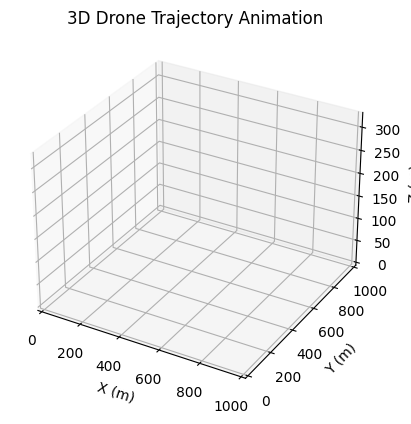

In [57]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# Prepara i dati della traiettoria (assumendo che 'trajectory' sia una lista di array [x, y, z])
traj_arr = np.array(trajectory)
x_data = traj_arr[:, 0]
y_data = traj_arr[:, 1]
z_data = traj_arr[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Crea gli oggetti per la linea tratteggiata (traiettoria) e il punto (drone)
line, = ax.plot([], [], [], 'k--', lw=1.5)  # linea tratteggiata
point, = ax.plot([], [], [], 'ro', markersize=8)  # drone come punto rosso

# Imposta i limiti degli assi (modifica se necessario)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)
ax.set_zlim(0, max(z_data)*1.1)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Drone Trajectory Animation')

def init():
    line.set_data([], [])
    line.set_3d_properties([])
    point.set_data([], [])
    point.set_3d_properties([])
    return line, point

def update(frame):
    # Disegna la linea dalla partenza fino al frame corrente
    line.set_data(x_data[:frame], y_data[:frame])
    line.set_3d_properties(z_data[:frame])
    # Posiziona il punto all'ultima posizione aggiornata
    point.set_data(x_data[frame-1:frame], y_data[frame-1:frame])
    point.set_3d_properties(z_data[frame-1:frame])
    return line, point

ani = animation.FuncAnimation(fig, update, frames=len(x_data),
                              init_func=init, interval=50, blit=True)

plt.show()
